# Data science project in Python - Voorspellingen maken met features

Doormiddel van numpy, pandas, matplotlib & SciKit-learn

Door Louis D'Hont - Elektronica-ICT - 2021

Dit project is het tweede deel van het data science project

In [4]:
# Importeren van gebruikte bibliotheken
import datetime
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
features = pd.read_csv("featuresDataFrame.csv", sep=',') 
features = features.drop(['Unnamed: 0'], axis=1)

### Omzetten van datatypes

De opgeslagen data is bij het inlezen opnieuw van het type int64, float64 en object. De data dat hiervoor een datetime was moet nu worden omgezet zodat er terug met kan worden gewerkt.

In [6]:
features['Datum creatie'] = pd.to_datetime(features['Datum creatie'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum vertrek'] = pd.to_datetime(features['Datum vertrek'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum terug'] = pd.to_datetime(features['Datum terug'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')

#features['Aantal dagen tot vertrek'] = pd.to_datetime(features['Aantal dagen tot vertrek'])
features['Aantal dagen op reis'] = features['Aantal dagen op reis'].astype('string')
features['Aantal dagen tot vertrek'] = features['Aantal dagen tot vertrek'].astype('string')

#features['Aantal dagen tot vertrek'].dt.days

features.dtypes                                        

Status                               int64
Dossier jaar                         int64
Dossier nr.                          int64
Klantnummer                         object
Datum creatie               datetime64[ns]
Datum vertrek               datetime64[ns]
Datum terug                 datetime64[ns]
Totaalprijs                        float64
Betalingen dossier                 float64
Openstaand dossier                 float64
Land                                object
Bestemming                          object
Reistype                            object
Aantal reizigers                     int64
Aantal dagen tot vertrek            string
Aantal dagen op reis                string
dtype: object

#### Bekijken van features

In het onderstaande dataframe staan alle gegevens die kunnen worden gebruikt als feature. Het spreekt voor zich dat er uiteraard ook enkele minder relevante zaken zoals klantnummer en dergelijke zullen worden weggelaten uit het finale dataframe waarmee de modellen zullen worden opgebouwd. 

In [7]:
features

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis
0,1,2011,189,030abd64a9a637e5,2011-10-21 12:48:33,2012-04-27,2012-04-29,1600.00,1600.00,0.0,nl,Drents Friese Woud Drenthe,Ruitervakantie,6,188 days 11:11:27,2 days 00:00:00
1,1,2011,190,030abd64a9a637e5,2011-10-21 12:56:19,2012-04-27,2012-04-29,1600.00,1600.00,0.0,nl,Drents Friese Woud Drenthe,Ruitervakantie,6,188 days 11:03:41,2 days 00:00:00
2,1,2011,191,0517092b51559410,2011-10-26 11:34:16,2012-04-30,2012-04-05,941.66,941.66,0.0,nl,Duitsland,Ruitervakantie,2,186 days 12:25:44,25 days 00:00:00
3,1,2011,192,b931980e4256363a,2011-10-26 15:36:35,2012-06-29,2012-11-07,7201.50,7201.50,0.0,nl,Ijsland,Ruitervakantie,3,246 days 08:23:25,131 days 00:00:00
4,1,2011,200,7853bb1516f198d9,2011-08-11 16:15:15,2012-04-13,2012-04-22,4291.68,4291.68,0.0,be,Jordanië,Ruitervakantie,3,245 days 07:44:45,9 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,1,2021,20210063,987976e947ed0146,2021-05-22 14:02:13,2021-04-08,2021-06-08,335.00,0.00,335.0,nl,Nederland,Weekendje weg,1,44 days 14:02:13,61 days 00:00:00
3961,1,2021,20210064,48261055dcd91db8,2021-05-22 19:52:22,2021-08-08,2021-08-15,1020.00,0.00,1020.0,be,Frankrijk,Ruitervakantie,2,77 days 04:07:38,7 days 00:00:00
3962,1,2021,20210065,2c3513ff809c5027,2021-05-23 16:02:09,2021-08-08,2021-12-08,760.00,0.00,760.0,nl,Nederland,Weekendje weg,2,76 days 07:57:51,122 days 00:00:00
3963,0,2021,20210066,b1e8b8eaac7784a6,2021-05-23 19:07:14,2021-01-08,2021-08-08,1076.10,0.00,1076.1,nl,Frankrijk,Ruitervakantie,2,135 days 19:07:14,212 days 00:00:00


# Evalueren en selecteren van features

Enkele interessante features die in de data te vinden zijn:

 - **Status**: De status (1 of 0) heeft aan of de boeking bevestigd of geannuleerd is.
 - **Dossier jaar**: Het jaar waarin het dossier werdt aangemaakt.
 - **Dossier nr.**: Een nummer (id) dat iedere reis identificeert.
 - **Klantnummer**: Het nummer dat een klant identificeert.
 - **Datum creatie**: Deze feature heeft een datum met uur, minuten en seconden. Deze waardes kunnen interessant zijn om te kijken hoeveel tijd er tussen een boeking en de reis vertrek datum zit.
 - **Datum vertrek**: De datum waarop een reis start.
 - **Datum terug**: De datum waarop de reizigers terugkeren naar hun thuisland.
 - **Totaalprijs**: De prijs die ze in totaal betalen voor de reis.
 - **Betalingen dossier**: Het bedrag dat al betaald is.
 - **Openstaand dossier**: Het bedrag dat nog moet betaald worden om te kunnen voldoen en te mogen vertrekken op reis.
 - **Land**: Het thuisland van de reiziger.
 - **Bestemming**: Het land waar de reiziger naartoe geweest is.
 - **Reistype**: Het type reis dat de reiziger neemt.
 - **Aantal reizigers**: Het aantal personen die mee opreis gaan.
 - **Aantal dagen tot vertrek**: Het berekende aantal dagen (tijd) tussen het aanmaken van een account en de vertrek datum.
 - **Aantal dagen op reis**: Het berekende aantal dagen dat de reis duurde.


## Correlatie matrix tussen features

Onderstaande matrix toont aan hoe de features met elkaar verbonden zijn op een schaal van 0 tot 1. Hoe hoger de waarde hoe hoger de correlatie is tussen de 2 waarden. De correlatie tussen de eigen data is steeds 1 wat ook wordt weergegeven in de diagonale donkerrode lijn.

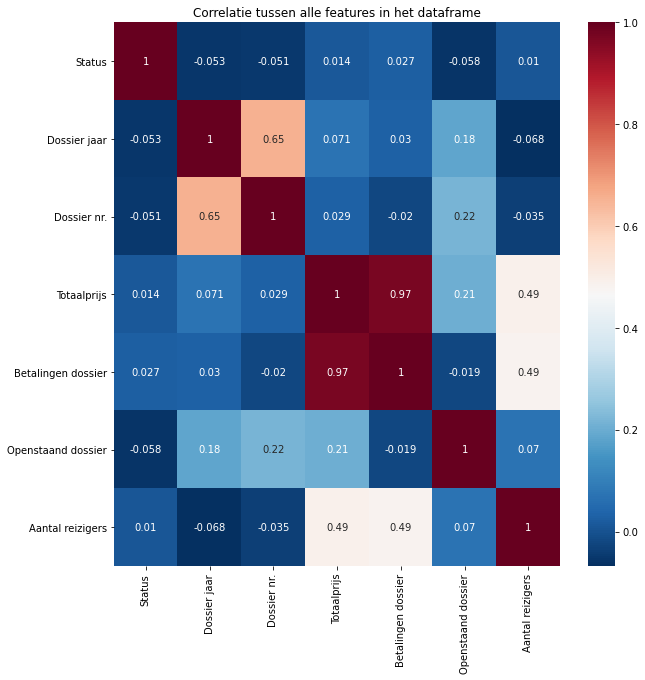

In [8]:
plt.figure(figsize=(10,10))
plt.title('Correlatie tussen alle features in het dataframe')
seaborn.heatmap((features).corr(), annot=True, cmap="RdBu_r")
plt.show();

## Selecteren van het meest interessante model

In de volgende stappen worden enkele modellen getest om te zien hoe de modellen het doen op de train en test data.

### KNN

KNN is het eenvoudigste model. Het onthoudt de trainingsgegevens en zet de te voorspellen gegevens op dezelfde grafiek. Om elk doel te voorspellen, zoekt het KNN-model het dichtstbijzijnde punt in de traingsdata en stelt de waarde van het te voorspellen gegeven in op dat van de dichtstbijzijnde buur. Er kan ingesteld worden hoeveel buren het model moet bevatten om een waarde aan het doel te geven. Meer of minder buren kiezen kan een goede of slechte invloed hebben op het classificerings model.

### Decision tree

Een decision tree is een algoritme dat gebruikmaakt van een boomachtig model om beslissingen te maken en hun mogelijke gevolgen te gaan afwegen. Het is een algoritme dat alleen voorwaardelijke controle-instructies bevat en op basis daarvan tot een voorspelling komt.

Beslisbomen hebben 2 hoofdzakelijke types:

* Classification tree is wanneer de voorspelde uitkomst de klasse is waartoe de gegevens behoren.
* Regression is wanneer de voorspelde uitkomst als een reëel getal kan worden beschouwd (bijvoorbeeld de prijs van een huis of de leeftijd van een persoon).

### Opsplitsen van train en test data

Onderstaande ...

In [9]:
y = features['Status'].to_numpy().astype(int)
X = features.drop(['Status', 'Klantnummer', 'Datum creatie', 'Datum vertrek', 'Datum terug', 'Land', 'Bestemming', 'Reistype', 'Aantal dagen tot vertrek', 'Aantal dagen op reis'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.3)

In [10]:
X

,Dossier jaar,Dossier nr.,Totaalprijs,Betalingen dossier,Openstaand dossier,Aantal reizigers
0,2011,189,1600.00,1600.00,0.0,6
1,2011,190,1600.00,1600.00,0.0,6
2,2011,191,941.66,941.66,0.0,2
3,2011,192,7201.50,7201.50,0.0,3
4,2011,200,4291.68,4291.68,0.0,3
...,...,...,...,...,...,...
3960,2021,20210063,335.00,0.00,335.0,1
3961,2021,20210064,1020.00,0.00,1020.0,2
3962,2021,20210065,760.00,0.00,760.0,2
3963,2021,20210066,1076.10,0.00,1076.1,2


In [11]:
print("Shape van de data:", X.shape)
print("Shape van de target data:", y.shape)

Shape van de data: (3965, 6)
Shape van de target data: (3965,)


## modellen evalueren en vergelijken

### Het KNN-model om types te definiëren

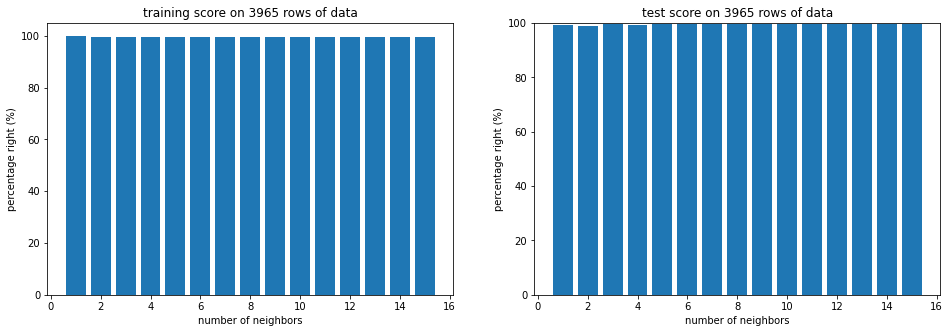

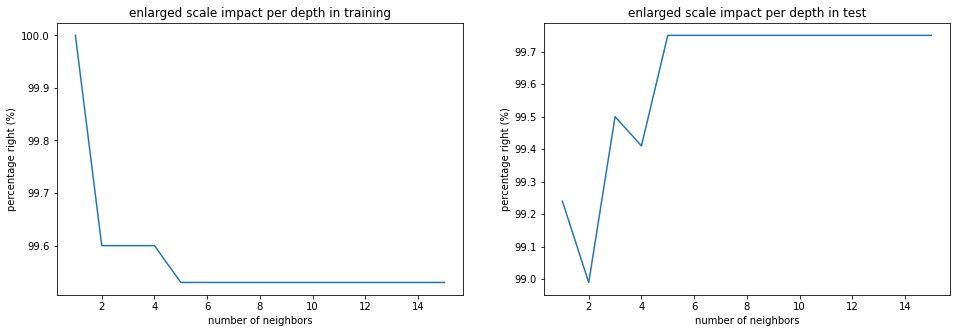

In [12]:
trainingScore = []
testScore = []
neighbors = 15

for n in range(1, neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    
    trainingScore.append(round(knn.score(X_train,y_train) * 100, 2))
    testScore.append(round(knn.score(X_test,y_test) * 100, 2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
objects = range(1, neighbors + 1)

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('training score on ' + str(len(X)) + ' rows of data')
ax1.set_ylabel('percentage right (%)')
ax1.set_xlabel('number of neighbors')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('test score on ' + str(len(X)) + ' rows of data')
ax2.set_ylabel('percentage right (%)')
ax2.set_xlabel('number of neighbors')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.plot(objects, trainingScore)
ax1.set_title('enlarged scale impact per depth in training')
ax1.set_ylabel('percentage right (%)')
ax1.set_xlabel('number of neighbors')

ax2.plot(objects, testScore)
ax2.set_title('enlarged scale impact per depth in test')
ax2.set_ylabel('percentage right (%)')
ax2.set_xlabel('number of neighbors')
plt.show()

### Het decision tree classifier systeem gebruiken om types te definiëren

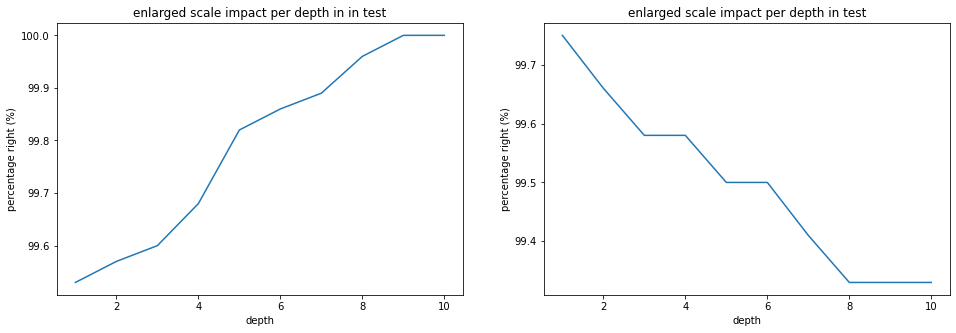

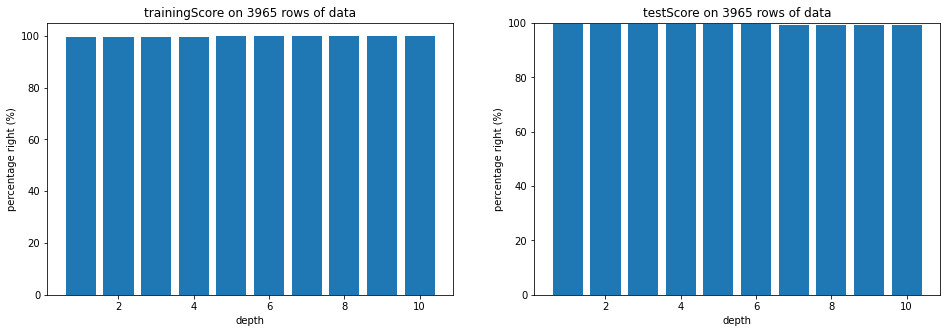

In [13]:
trainingScore = []
testScore = []
depth = 10

for n in range(1, depth+1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScore.append(round(treeModel.score(X_train,y_train) * 100, 2))
    testScore.append(round(treeModel.score(X_test,y_test) * 100, 2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
objects = range(1, depth+1)

ax1.plot(objects, trainingScore)
ax1.set_title('enlarged scale impact per depth in in test')
ax1.set_ylabel('percentage right (%)')
ax1.set_xlabel('depth')

ax2.plot(objects, testScore)
ax2.set_title('enlarged scale impact per depth in test')
ax2.set_ylabel('percentage right (%)')
ax2.set_xlabel('depth')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('trainingScore on ' + str(len(X)) + ' rows of data')
ax1.set_ylabel('percentage right (%)')
ax1.set_xlabel('depth')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('testScore on ' + str(len(X)) + ' rows of data')
ax2.set_ylabel('percentage right (%)')
ax2.set_xlabel('depth')
plt.show()

In [14]:
kFold = KFold(n_splits=5, shuffle=True, random_state=42)

knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

res_df = pd.DataFrame(cross_validate(knn, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(knn, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
res_df

Average cross-validation score: 0.81


,fit_time,score_time,test_score,train_score
0,0.011808,0.027689,0.996217,0.995902
1,0.009502,0.018908,0.992434,0.996847
2,0.009309,0.018319,0.997478,0.995586
3,0.009505,0.019165,0.997478,0.995586
4,0.009356,0.019134,0.996217,0.995902


In [15]:
lr = LinearRegression().fit(X_train, y_train)

res_df = pd.DataFrame(cross_validate(lr, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(lr, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
res_df

Average cross-validation score: -96896.85


,fit_time,score_time,test_score,train_score
0,0.003679,0.002460,0.005428,0.005707
1,0.003692,0.001757,-0.000429,0.006485
2,0.004075,0.002019,-0.009928,0.007432
3,0.002750,0.001621,-0.003085,0.007021
4,0.003298,0.002319,-0.004348,0.007927


In [16]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

res_df = pd.DataFrame(cross_validate(tree, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(tree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
res_df

Average cross-validation score: 0.61


,fit_time,score_time,test_score,train_score
0,0.009967,0.002614,0.992434,0.997793
1,0.010089,0.002906,0.989912,0.998108
2,0.009736,0.002112,0.992434,0.997163
3,0.008668,0.001997,0.994956,0.998108
4,0.007824,0.001989,0.993695,0.997793


In [104]:
#scatter_matrix(df, figsize=(10, 10))
#plt.show()

In [ ]:
#print("Average cross-validation score: {:.2f}".format(scores.mean()))